# Training Notebook

In [41]:
import glob
import os
import numpy as np

import cv2
import xml.etree.ElementTree as ET

import inference_utils

## Displaying in-cell
from IPython.display import Image
import matplotlib.pyplot as plt

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [2]:
class FishCounter(object):
    import cv2

    def __init__(self, model_config, model_weights):
        self.net = cv2.dnn.readNetFromDarknet(model_config, model_weights)
        self.input_width = 416
        self.input_height = 416

    def inference(self, frame):
        """Run inference on single frame."""
        # Create a 4D blob from a frame.
        blob = cv2.dnn.blobFromImage(
            frame,
            1 / 255,
            (self.input_width, self.input_height),
            [0, 0, 0],
            1,
            crop=False,
        )

        # Sets the input to the network
        self.net.setInput(blob)

        # Runs the forward pass to get output of the output layers
        outs = self.net.forward(self._get_outputs_names(net=self.net))

    def _get_outputs_names(net):
        """Get the names of the output layers."""
        # Get the names of all the layers in the network
        layersNames = net.getLayerNames()
        # Get the names of the output layers, i.e. the layers with unconnected outputs
        return [layersNames[i - 1] for i in net.getUnconnectedOutLayers()]

    def get_annotated_frame(self):
        """Returns main frame with fish highlighted."""
        frame = self.frame.copy()

In [5]:
def get_dimensions_of_annotations(fpath):
    """Extracts dimensions of annotation boxes from xml file for image."""

    class_label = "herring"  # TODO: Will need to accomodate multiple classes

    tree = ET.parse(fpath)
    root = tree.getroot()

    xmins = []
    ymins = []
    xmaxs = []
    ymaxs = []
    for o in root.iter("object"):
        if o.find("name").text == class_label:
            xmins.append(eval(o[4][0].text))
            ymins.append(eval(o[4][1].text))
            xmaxs.append(eval(o[4][2].text))
            ymaxs.append(eval(o[4][3].text))
    return xmins, ymins, xmaxs, ymaxs


def bb_intersection_over_union(boxA, boxB):
    """Compute the intersection over union by taking the intersection area and dividing
    it by the sum of prediction + ground-truth areas - the interesection area"""
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    print(interArea)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    print(boxAArea)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    print(boxBArea)

    return interArea / float(boxAArea + boxBArea - interArea)

#### Set paths

In [53]:
DATA_DIR = os.path.join("..", "data", "Herring")

TRAINING_DIR = os.path.join(DATA_DIR, "Training", "IRWA 2017 (Large+annotations)")
TESTING_DIR = os.path.join(DATA_DIR, "Testing")

os.path.isdir(DATA_DIR)  # assertion that we are pointed to correct folder
WEIGHTS_DIR = os.path.join("..", "weights_and_config")
HERRING_WEIGHTS = os.path.join(WEIGHTS_DIR, "Herring")


folder = "Batch 1"
# Load images and annotations
images = glob.glob(os.path.join(TRAINING_DIR, folder, "*.JPG")) + glob.glob(
    os.path.join(TRAINING_DIR, folder, "*.jpg")
)
annotations = glob.glob(os.path.join(TRAINING_DIR, f"{folder} annotations", "*.xml"))
print("{} images. Annotations: {}".format(len(images), len(annotations)))

144 images. Annotations: 108


## Scoring annotations against inference
**Requirements:** 2 folders: 1 with annotations (e.g. XML), 1 with images
* **Steps:**
  * 1) Run loop on images extracting predicted boxes from each image
  * 2) Scan filenames until box is properly extracted
  * 3) **Scoring Method:**
    * For each annotation find closest/any overlapping boxes (scoring the greater of number of either the annotated or predicted set distinctly)
    * Return average IOU for image
    * Return total number of correctly detected fish

../data/Herring/Training/IRWA 2017 (Large+annotations)/Batch 1/2_2017-04-14_10-51-06_large.jpg [[6, 110, 107, 56]]
5184
6156
5635
IOU Score: 0.78462237021341


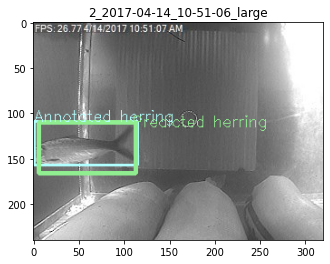

In [17]:
def display_image_comparison(img_path=None, annotated_box=None, predicted_box=None):
    import matplotlib.pyplot as plt
    import cv2

    """Display an image with optional annotated class and predicted class within notebook for comparison.
    image_path: image path to location in memory
    annotated_box: corners in format xmin,xmax,ymin,ymax
    """

    label = "herring"

    img_name = img_path.split("/")[-1].split(".")[0]
    frame = cv2.imread(img_path)

    # Annotated
    cv2.rectangle(
        frame,
        (annotated_box[0], annotated_box[1]),
        (annotated_box[2], annotated_box[3]),
        (178, 255, 255),
        2,
    )

    # Annotated
    # Predicted
    if predicted_box is not None:
        cv2.rectangle(
            frame,
            (predicted_box[0], predicted_box[1]),
            (predicted_box[2], predicted_box[3]),
            (144, 238, 144),
            3,
        )
    cv2.putText(
        frame,
        "Annotated " + label,
        (annotated_box[0], annotated_box[1]),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.55,
        (178, 255, 255),
        1,
    )
    cv2.putText(
        frame,
        "Predicted " + label,
        (annotated_box[1], annotated_box[2]),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.55,
        (144, 238, 144),
        1,
    )
    plt.imshow(frame)
    plt.title(img_name)
    plt.show()


## Example files
# 1 count: ../data/Herring/Training/IRWA 2017 (Large+annotations)/Batch 1/2_2017-04-14_11-42-13_large.jpg
# herring_image = "../data/Herring/Training/IRWA 2017 (Large+annotations)/Batch 1/2_2017-04-14_11-42-13_large.jpg"
# boxes = [[56, 134, 97, 48]]

# 1 count: ../data/Herring/Training/IRWA 2017 (Large+annotations)/Batch 1/2_2017-04-14_10-51-06_large.jpg
herring_image = "../data/Herring/Training/IRWA 2017 (Large+annotations)/Batch 1/2_2017-04-14_10-51-06_large.jpg"
boxes = [[6, 110, 107, 56]]

print(herring_image, boxes)
# Get index of annotation path files that contains the path to annotated file matching the non-annoated file
idx = [
    i
    for i in range(len(annotations))
    if herring_image.split("/")[-1].split(".")[0] in annotations[i]
][
    0
]  # Get the first element (multiple matches do not matter)


xmins, xmaxs, ymins, ymaxs = get_dimensions_of_annotations(fpath=annotations[idx])

# Predicted
left, top, width, height = boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]
xmin, ymin, xmax, ymax = left, top, left + width, top + height
predicted_box = xmin, ymin, xmax, ymax
# Annotated
annotated_box = xmins[0], xmaxs[0], ymins[0], ymaxs[0]
print("IOU Score:", bb_intersection_over_union(boxA=predicted_box, boxB=annotated_box))

display_image_comparison(
    img_path=herring_image, annotated_box=annotated_box, predicted_box=predicted_box
)  # predicted_box

## Evaluation

In [39]:
## Initialize the parameters
# Confidence threshold
conf_threshold = 0.5
# Non-maximum suppression threshold (maximum bounding box)
nms_threshold = 0.05
input_width = 416  # Width of network's input image
input_height = 416  # Height of network's input image

# Load class name
classes = "Herring"
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = os.path.join(HERRING_WEIGHTS, "herring.cfg")
modelWeights = os.path.join(HERRING_WEIGHTS, "herring_final.weights")
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)


iou_scores = []
annotated_counts = []
predicted_counts = []
# Loop through annotated files
for a in annotations:
    name = a.split("/")[-1].split(".")[0]

    # Loop through image files (non-annotated) to make a prediction on
    for herring_image in images:

        if name not in herring_image:
            continue

        frame = cv2.imread(herring_image)

        # # Get frame from the video
        # hasFrame, frame = cap.read()

        input_width, input_height, _ = frame.shape
        input_width = input_height = min(input_width, input_height)
        input_width = 416  # Width of network's input image
        input_height = 416  # Height of network's input image

        print(input_height, input_width)
        # Create a 4D blob from a frame.
        blob = cv2.dnn.blobFromImage(
            frame, 1 / 255, (input_width, input_height), [0, 0, 0], 1, crop=False
        )

        # Sets the input to the network
        net.setInput(blob)

        # Runs the forward pass to get output of the output layers
        outs = net.forward(inference_utils.get_outputs_names(net=net))
        # break
        # Remove the bounding boxes with low confidence
        counts, boxes = inference_utils.postprocess(
            frame=frame,
            outs=outs,
            tracker=None,
            conf_threshold=conf_threshold,
            nms_threshold=nms_threshold,
            classes=classes,
        )

        print(boxes)
        # cv2.imshow(herring_image, frame)
        # cv2.waitKey(0)
        print("Counts:", counts)

        # Get score
        xmins, xmaxs, ymins, ymaxs = get_dimensions_of_annotations(fpath=a)
        # Predicted
        if len(boxes) == 0:  # If nothing was predicted
            boxes = [[0, 0, 0, 0]]
        left, top, width, height = boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]
        xmin, ymin, xmax, ymax = left, top, left + width, top + height
        predicted_box = xmin, ymin, xmax, ymax
        # Annotated
        if len(xmins) == 0:  # If nothing was annotated
            annotated_box = [0, 0, 0, 0]
            annotated_count = 0
        else:
            annotated_box = xmins[0], xmaxs[0], ymins[0], ymaxs[0]
            annotated_count = 1

        annotated_counts.append(counts)
        predicted_counts.append(annotated_count)
        iou_score = bb_intersection_over_union(boxA=predicted_box, boxB=annotated_box)
        iou_scores.append(iou_score)
        print("IOU Score:", iou_score)

        print()
    cv2.destroyAllWindows()

416 416
BOXES [] () []
counts 0
[]
Counts: 0
0
1
4640
IOU Score: 0.0

416 416
[0.32865852 0.6587873  0.30487534 0.20038645 0.8971311  0.8971311 ]
BOXES [[56, 134, 97, 48]] [0] [0]
counts 1
[[56, 134, 97, 48]]
Counts: 1
3626
4802
3700
IOU Score: 0.743642329778507

416 416
[0.1878179  0.57741845 0.33692092 0.23485109 0.91039896 0.91039896]
BOXES [[6, 110, 107, 56]] [0] [0]
counts 1
[[6, 110, 107, 56]]
Counts: 1
5184
6156
5635
IOU Score: 0.78462237021341

416 416
BOXES [] () []
counts 0
[]
Counts: 0
0
1
6450
IOU Score: 0.0

416 416
[0.3371907  0.57600754 0.24674599 0.17456466 0.8827041  0.8827041 ]
BOXES [[68, 117, 78, 41]] [0] [0]
counts 1
[[68, 117, 78, 41]]
Counts: 1
2686
3318
3638
IOU Score: 0.62903981264637

416 416
[0.57825655 0.73355365 0.7512411  0.4102464  0.61980534 0.61980534]
BOXES [[65, 127, 240, 98]] [0] [0]
counts 1
[[65, 127, 240, 98]]
Counts: 1
6486
23859
6486
IOU Score: 0.2718471017226204

416 416
BOXES [] () []
counts 0
[]
Counts: 0
0
1
9860
IOU Score: 0.0

416 416
BOXE

In [43]:
print("average IOU", np.mean(iou_scores))
print("Total annotated counts", sum(annotated_counts))
print("Total predicted counts", sum(predicted_counts))

average IOU 0.31280921624893643
Total annotated counts 65
Total predicted counts 94
